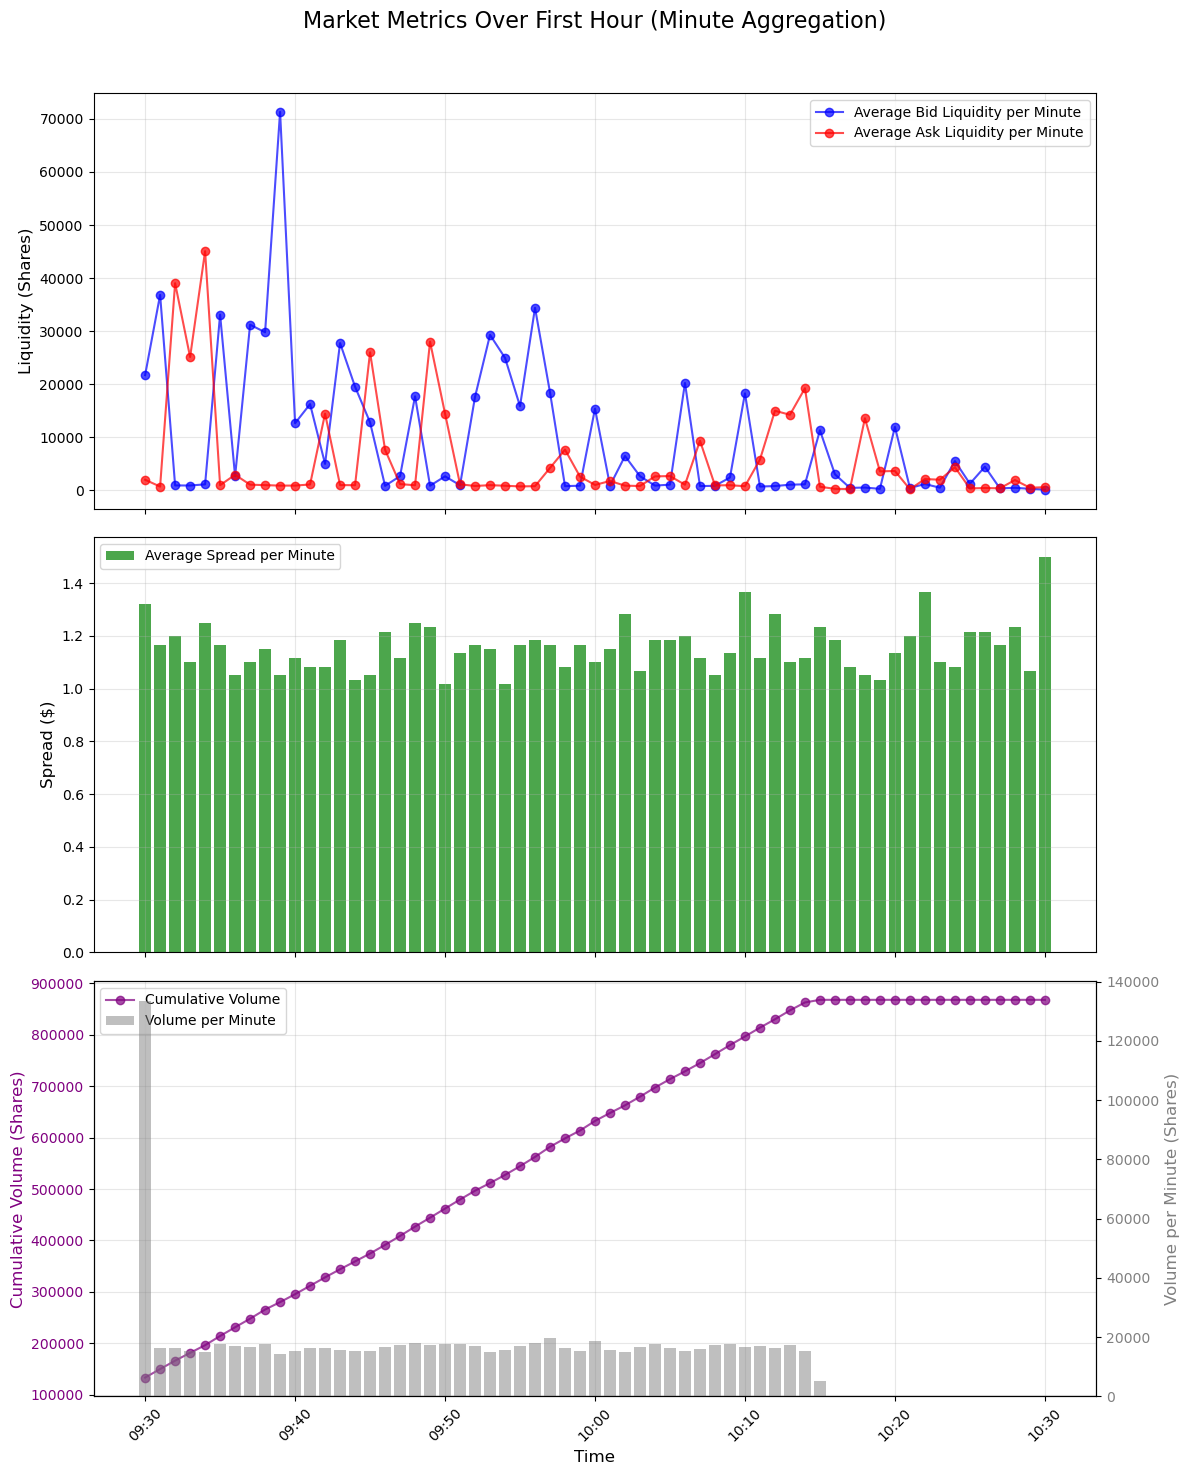

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 读取快照数据
df = pd.read_pickle(r'log\rmsc03_two_hour\SNAPSHOT_AGENT.bz2')
df = df.reset_index()

# 确保EventTime为 datetime 类型并设置为索引
df['EventTime'] = pd.to_datetime(df['EventTime'])
df = df.set_index('EventTime').sort_index()

# 计算时间范围（取第一条记录时间作为起点，加1小时）
start_time = df.index[1]
end_time = start_time + pd.Timedelta(hours=1)
# 筛选前一小时的数据
df = df[(df.index >= start_time) & (df.index <= end_time)]

# 分离三种事件类型的数据
liquidity_events = df[df['EventType'] == 'LIQUIDITY_1PCT']
spread_events = df[df['EventType'] == 'SPREAD']
volume_events = df[df['EventType'] == 'VOLUME']

# 提取流动性数据并按分钟聚合
liquidity_data = pd.DataFrame({
    'bid_liquidity': [event['bid_liquidity'] for event in liquidity_events['Event']],
    'ask_liquidity': [event['ask_liquidity'] for event in liquidity_events['Event']]
}, index=liquidity_events.index)
# 按分钟聚合，计算每分钟平均值
liquidity_data_min = liquidity_data.resample('1min').mean().dropna()

# 提取价差数据并按分钟聚合
spread_data = pd.DataFrame({
    'spread': [event['spread'] for event in spread_events['Event']]
}, index=spread_events.index)
# 按分钟重采样并计算平均值
spread_data_min = spread_data.resample('1min').mean().dropna()

# 提取交易量数据并按分钟聚合
volume_data = pd.DataFrame({
    'volume': [event['volume'] for event in volume_events['Event']]
}, index=volume_events.index)
# 按分钟聚合交易量
volume_data_min = volume_data.resample('1min').sum().dropna()
# 计算累积交易量（按分钟）
volume_data_min['cumulative_volume'] = volume_data_min['volume'].cumsum()

# 创建可视化图表
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Market Metrics Over First Hour (Minute Aggregation)', fontsize=16)

# 1. 流动性图表（按分钟聚合）
axes[0].plot(liquidity_data_min.index, liquidity_data_min['bid_liquidity'], 
             label='Average Bid Liquidity per Minute', color='blue', alpha=0.7, marker='o')
axes[0].plot(liquidity_data_min.index, liquidity_data_min['ask_liquidity'], 
             label='Average Ask Liquidity per Minute', color='red', alpha=0.7, marker='o')
axes[0].set_ylabel('Liquidity (Shares)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 2. 价差图表（按分钟聚合）
axes[1].bar(spread_data_min.index, spread_data_min['spread'], 
            label='Average Spread per Minute', color='green', alpha=0.7, width=0.8/24/60)
axes[1].set_ylabel('Spread ($)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# 3. 交易量图表（按分钟聚合）
ax2 = axes[2]  # 左侧主轴
ax3 = ax2.twinx()  # 创建右侧副轴

# 左侧轴：累积交易量（线图）
line = ax2.plot(volume_data_min.index, volume_data_min['cumulative_volume'], 
                label='Cumulative Volume', color='purple', alpha=0.7, marker='o')
ax2.set_ylabel('Cumulative Volume (Shares)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# 右侧轴：每分钟交易量（柱状图）
bars = ax3.bar(volume_data_min.index, volume_data_min['volume'], 
               label='Volume per Minute', color='gray', alpha=0.5, width=0.8/24/60)
ax3.set_ylabel('Volume per Minute (Shares)', fontsize=12, color='gray')
ax3.tick_params(axis='y', labelcolor='gray')

# 合并图例
lines = line
labels = [l.get_label() for l in lines]
labels.append(bars.get_label())
ax2.legend(lines + [bars], labels, fontsize=10)

ax2.set_xlabel('Time', fontsize=12)
ax2.grid(alpha=0.3)

# 设置x轴时间格式
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 只显示小时和分钟
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()

# 保存图表
fig.savefig('market_metrics_all_minute_agg.png', dpi=300, bbox_inches='tight')

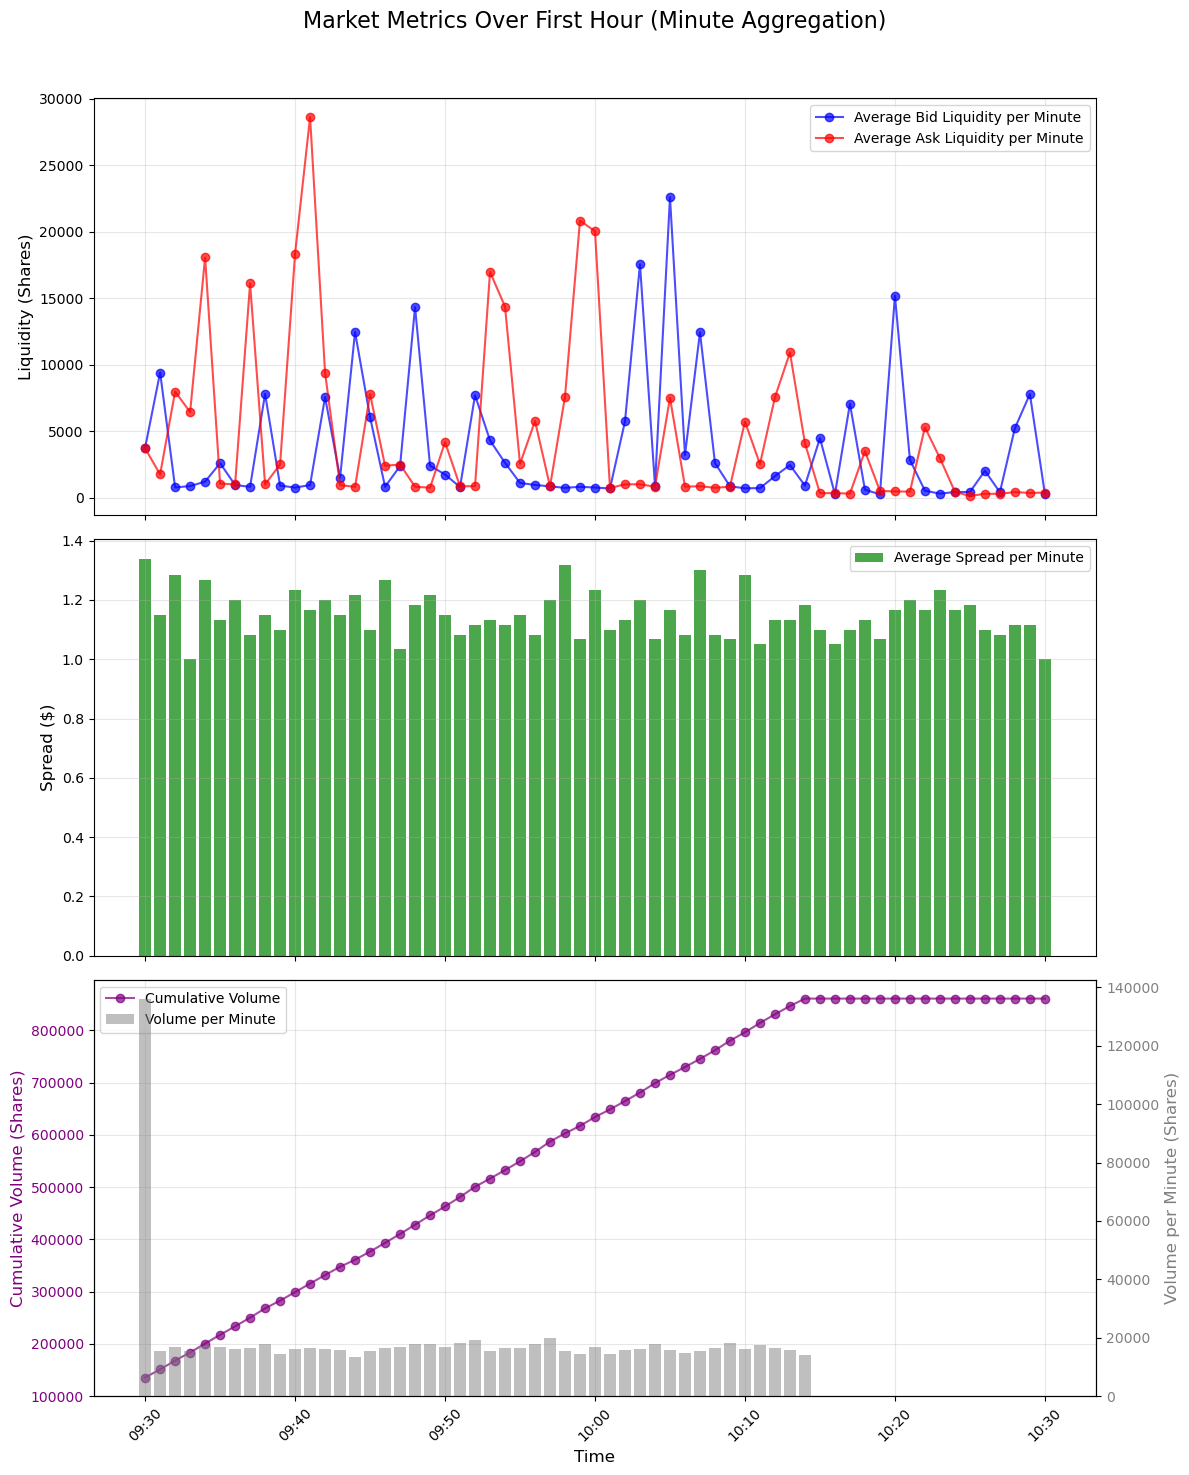

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 读取快照数据
df = pd.read_pickle(r'log\rmsc04_two_hour\SNAPSHOT_AGENT.bz2')
df = df.reset_index()

# 确保EventTime为 datetime 类型并设置为索引
df['EventTime'] = pd.to_datetime(df['EventTime'])
df = df.set_index('EventTime').sort_index()

# 计算时间范围（取第一条记录时间作为起点，加1小时）
start_time = df.index[1]
end_time = start_time + pd.Timedelta(hours=1)
# 筛选前一小时的数据
df = df[(df.index >= start_time) & (df.index <= end_time)]

# 分离三种事件类型的数据
liquidity_events = df[df['EventType'] == 'LIQUIDITY_1PCT']
spread_events = df[df['EventType'] == 'SPREAD']
volume_events = df[df['EventType'] == 'VOLUME']

# 提取流动性数据并按分钟聚合
liquidity_data = pd.DataFrame({
    'bid_liquidity': [event['bid_liquidity'] for event in liquidity_events['Event']],
    'ask_liquidity': [event['ask_liquidity'] for event in liquidity_events['Event']]
}, index=liquidity_events.index)
# 按分钟聚合，计算每分钟平均值
liquidity_data_min = liquidity_data.resample('1min').mean().dropna()

# 提取价差数据并按分钟聚合
spread_data = pd.DataFrame({
    'spread': [event['spread'] for event in spread_events['Event']]
}, index=spread_events.index)
# 按分钟重采样并计算平均值
spread_data_min = spread_data.resample('1min').mean().dropna()

# 提取交易量数据并按分钟聚合
volume_data = pd.DataFrame({
    'volume': [event['volume'] for event in volume_events['Event']]
}, index=volume_events.index)
# 按分钟聚合交易量
volume_data_min = volume_data.resample('1min').sum().dropna()
# 计算累积交易量（按分钟）
volume_data_min['cumulative_volume'] = volume_data_min['volume'].cumsum()

# 创建可视化图表
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Market Metrics Over First Hour (Minute Aggregation)', fontsize=16)

# 1. 流动性图表（按分钟聚合）
axes[0].plot(liquidity_data_min.index, liquidity_data_min['bid_liquidity'], 
             label='Average Bid Liquidity per Minute', color='blue', alpha=0.7, marker='o')
axes[0].plot(liquidity_data_min.index, liquidity_data_min['ask_liquidity'], 
             label='Average Ask Liquidity per Minute', color='red', alpha=0.7, marker='o')
axes[0].set_ylabel('Liquidity (Shares)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 2. 价差图表（按分钟聚合）
axes[1].bar(spread_data_min.index, spread_data_min['spread'], 
            label='Average Spread per Minute', color='green', alpha=0.7, width=0.8/24/60)
axes[1].set_ylabel('Spread ($)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# 3. 交易量图表（按分钟聚合）
ax2 = axes[2]  # 左侧主轴
ax3 = ax2.twinx()  # 创建右侧副轴

# 左侧轴：累积交易量（线图）
line = ax2.plot(volume_data_min.index, volume_data_min['cumulative_volume'], 
                label='Cumulative Volume', color='purple', alpha=0.7, marker='o')
ax2.set_ylabel('Cumulative Volume (Shares)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# 右侧轴：每分钟交易量（柱状图）
bars = ax3.bar(volume_data_min.index, volume_data_min['volume'], 
               label='Volume per Minute', color='gray', alpha=0.5, width=0.8/24/60)
ax3.set_ylabel('Volume per Minute (Shares)', fontsize=12, color='gray')
ax3.tick_params(axis='y', labelcolor='gray')

# 合并图例
lines = line
labels = [l.get_label() for l in lines]
labels.append(bars.get_label())
ax2.legend(lines + [bars], labels, fontsize=10)

ax2.set_xlabel('Time', fontsize=12)
ax2.grid(alpha=0.3)

# 设置x轴时间格式
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 只显示小时和分钟
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()

# 保存图表
fig.savefig('market_metrics_all_minute_agg.png', dpi=300, bbox_inches='tight')